In [11]:
# Set the number of number of OMP threads to 1
%env OMP_NUM_THREADS=1

# Update path including qFlex root
import sys, os
sys.path.insert(1, os.path.dirname('./../'))

from python import qflex
from python import utils
from python.ordering import order_circuit_simulation as order_lib
from python.circuits import generator
from progressbar import progressbar as pb
from io import StringIO
from multiprocessing import Pool
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np
import cirq

env: OMP_NUM_THREADS=1


In [12]:
# Get ordering
def get_ordering(grid, circuit):
    qubits = utils.GetGridQubits(StringIO('\n'.join(grid)))
    circuit = utils.GetCircuit(StringIO('\n'.join(circuit)), qubits)
    return order_lib.circuit_to_ordering(circuit, qubit_names=sorted(qubits))

In [13]:
# Define IBM Rochester layout
ibm_rochester = """001111100
001000100
111111111
100010001
111111111
001000100
111111111
100010001
111111111
001000100""".split('\n')

In [14]:
# Define IBM Rochester gates
ibm_rochester_1q_gates = ["x_1_2", "y_1_2", "t"]
ibm_rochester_2q_gate = "cx"

In [15]:
# Define pattern for the generation of RQCs
ibm_rochester_pattern = {
    'A': {(0, 1), (2, 3), (4, 6), (5, 9), (7, 8), (10, 11), (12, 13),
          (14, 15), (16, 19), (18, 27), (20, 21), (23, 24), (25, 26),
          (28, 32), (30, 31), (33, 34), (36, 37), (38, 41), (39, 42),
          (43, 44), (45, 46), (47, 48), (49, 50)},
    'B': {(0, 5), (1, 2), (3, 4), (6, 13), (7, 16), (9, 10), (11, 12),
          (15, 18), (17, 23), (19, 20), (21, 22), (24, 25), (26, 27),
          (29, 36), (30, 39), (32, 33), (34, 35), (37, 38), (40, 46),
          (41, 50), (42, 43), (44, 45), (48, 49)},
    'C': {(0, 5), (1, 2), (3, 4), (7, 16), (8, 9), (11, 17), (13, 14),
          (15, 18), (19, 20), (21, 28), (22, 23), (25, 29), (26, 27),
          (30, 39), (31, 32), (34, 40), (35, 36), (37, 38), (41, 50),
          (42, 43), (44, 51), (46, 47), (48, 52)},
}

# Define the sequence of patterns
ibm_rochester_sequence = "ABC"

# Define the depth of the circuit
ibm_rochester_depth = 4

# Get qubits map
qubits_map = {}
for x,k in enumerate(int(y) for x in ibm_rochester for y in x):
    if k != 0:
        qubits_map[len(qubits_map)] = x

In [16]:
# Get a generator of RQCs
prqcg = generator.PseudoRandomCircuitGenerator(
            generator.Device(ibm_rochester_pattern),
            ibm_rochester_1q_gates, 
            ibm_rochester_2q_gate)

def get_rqc():

    # Get a RQC ...
    rqc = prqcg.generate(ibm_rochester_sequence, ibm_rochester_depth, 123)
  
    # ... and remap them accordingly to layout
    rqc = [' '.join([str(int(x[0])+1)]+[x[1]]+[str(qubits_map[int(y)]) for y in x[2:]]) 
            for x in (x.split() for x in rqc.to_qsim_lines())]
  
    # Add layer of hadamard at the beginning and end
    rqc = ['0 h ' + str(qubits_map[q]) for q in range(len(qubits_map))] + rqc
    rqc = rqc + [str(int(rqc[-1].split()[0])+1) + ' h ' + str(qubits_map[q]) for q in range(len(qubits_map))]
  
    # Add number of qubits at the beginning
    rqc.insert(0, str(len(qubits_map)))
  
    return rqc

In [17]:
# Get ordering
ordering = get_ordering(ibm_rochester, [x for x in get_rqc() if len(x.split()) == 4])

In [18]:
# Simulate the circuit using qFlex
def run_simulation(final_state):

    options = {
      'circuit': get_rqc(),
      'ordering': ordering,
      'grid': ibm_rochester,
      'final_state' : final_state
    }
  
    return qflex.simulate(options)

with Pool(8) as pool:
    results = []
    for _ in pb(range(10)):
        results.extend(pool.map(run_simulation, [bin(np.random.randint(2**len(qubits_map)))[2:].zfill(len(qubits_map)) for _ in range(32)]))

100% (10 of 10) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


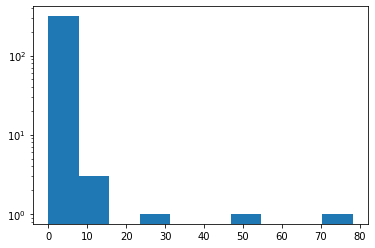

In [19]:
N = 2 ** (len(qubits_map))
plt.hist([N * np.abs(x[0][1])**2 for x in results])
plt.yscale('log')
plt.show()